In [1]:
from simulate_costs import *
from bootstrap_demand import *

import pandas as pd
import seaborn as sns
import statsmodels.stats.weightstats as sms
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
demands = pd.read_csv("../foodstuffs-data/FoodstuffsDemands.csv")
stores = demands.Supermarket.values.tolist()
demands = transform_demand(demands)
demands.head()

,Supermarket,Date,Demand,Weekday,DayType
0,Four Square Alberton,2022-07-04,1,0,Weekdays
1,Four Square Botany Junction,2022-07-04,1,0,Weekdays
2,Four Square Cockle Bay,2022-07-04,3,0,Weekdays
3,Four Square Ellerslie,2022-07-04,2,0,Weekdays
4,Four Square Everglade,2022-07-04,2,0,Weekdays


In [3]:
durations = pd \
    .read_csv("../route-generation/output/TravelCosts.csv") \
    .set_index(["From", "To"])
durations.head()

Distance   Duration
From             To                                       
New World Albany New World Albany       0.00000   0.000000
                 New World Birkenhead  15.70707  23.833833
                 New World Botany      35.83163  49.946667
                 New World Browns Bay   5.00226  10.337833
                 New World Devonport   17.81659  29.654833

In [4]:
selected_saturday = pd \
    .read_csv("../linear-program/output/selectedRoutesSaturday.csv") \
    .drop(columns=["RouteNum"])
selected_saturday.head()

,Route,TruckType,RouteCost
0,"['Warehouse', 'New World Papakura', ""Pak 'n Sa...",OwnedTruck,294.5460
1,"['Warehouse', 'New World Mt Roskill', 'New Wor...",OwnedTruck,192.6705
2,"['Warehouse', ""Pak 'n Save Wairau Road"", 'New ...",OwnedTruck,332.3620
3,"['Warehouse', 'New World Birkenhead', 'Four Sq...",OwnedTruck,432.4040
4,"['Warehouse', 'Four Square Alberton', 'New Wor...",OwnedTruck,260.3805


In [5]:
selected_weekday = pd \
    .read_csv("../linear-program/output/selectedRoutesWeekday.csv") \
    .drop(columns=["RouteNum"])
selected_weekday.head()

,Route,TruckType,RouteCost
0,"['Warehouse', 'Four Square Glen Eden', ""Pak 'n...",OwnedTruck,317.127667
1,"['Warehouse', ""Pak 'n Save Lincoln Road"", 'War...",OwnedTruck,104.192500
2,"['Warehouse', ""Pak 'n Save Westgate"", 'Warehou...",OwnedTruck,118.685417
3,"['Warehouse', 'Four Square Everglade', 'New Wo...",OwnedTruck,271.918833
4,"['Warehouse', 'Four Square Alberton', 'Four Sq...",OwnedTruck,387.919750


In [6]:
def calculate_total_cost(saturday_demands, weekday_demands, extra_trucks=0):
    trucks = 12 + extra_trucks
    saturday_runs = simulate_runs(
        selected_saturday, saturday_demands, durations, "Saturday", trucks=trucks
    )
    
    weekday_runs = simulate_runs(
        selected_weekday, weekday_demands, durations, "Weekdays", trucks=trucks
    )
    
    return sum(saturday_runs.Cost) + sum(weekday_runs.Cost) + extra_trucks*200000


In [7]:
runs = 20
normal_costs = []
extra_costs = []

for i in range(runs):
    print(f"Run {i+1}")
    saturday_demands = bootstrap_demand(260, stores, demands, "Saturday")
    weekday_demands = bootstrap_demand(1300, stores, demands, "Weekdays")
    
    normal_costs.append(calculate_total_cost(saturday_demands, weekday_demands))
    extra_costs.append(calculate_total_cost(saturday_demands, weekday_demands, extra_trucks=1))

Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9
Run 10
Run 11
Run 12
Run 13
Run 14
Run 15
Run 16
Run 17
Run 18
Run 19
Run 20


In [8]:
print(f"Mean Cost without Extra Trucks: ${round(np.mean(normal_costs), 2)}")
print(f"Mean Cost with One Extra Truck: ${round(np.mean(extra_costs), 2)}")

Mean Cost without Extra Trucks: $7294946.01
Mean Cost with One Extra Truck: $7490372.07


In [9]:
costs = pd.DataFrame({
    "Normal": normal_costs,
    "OneExtraTruck": extra_costs
})

costs.head()

,Normal,OneExtraTruck
0,7.299726e+06,7.499726e+06
1,7.306728e+06,7.496280e+06
2,7.274222e+06,7.474222e+06
3,7.299955e+06,7.497342e+06
4,7.303397e+06,7.498173e+06


In [10]:
def plot_pdf(data, title=None, xlabel=None):
    bin_range = lambda data: range(min(data), max(data) + 2)

    fig, ax = plt.subplots()

    ax.hist(
        data,
        density=True,
        alpha=0.2,
        histtype="stepfilled"
    )
    
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Probability density")


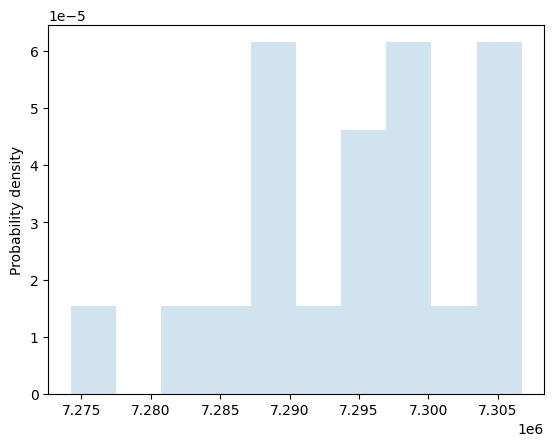

In [11]:
plot_pdf(costs.Normal)

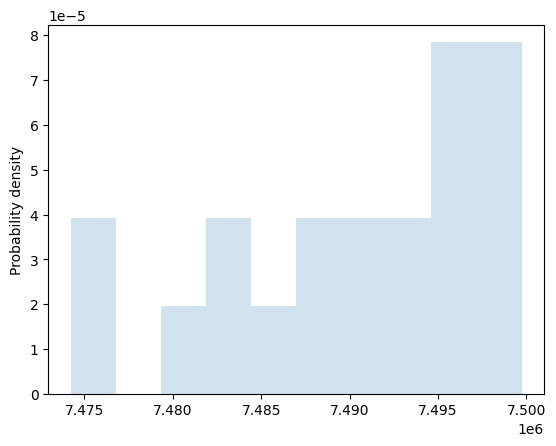

In [12]:
plot_pdf(costs.OneExtraTruck)

<AxesSubplot: xlabel='Simulation', ylabel='Cost'>

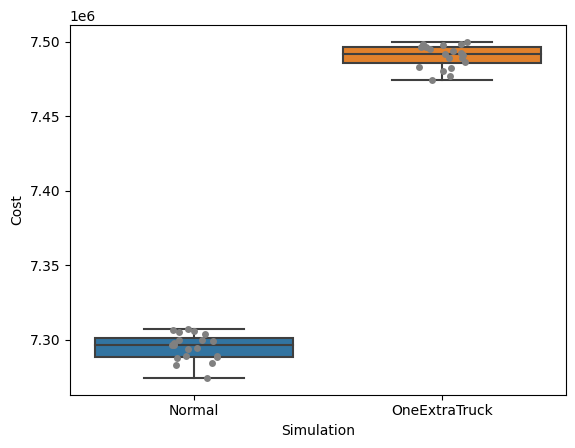

In [13]:
pivoted_costs = costs.melt(var_name="Simulation", value_name="Cost")
sns.boxplot(x="Simulation", y="Cost", data=pivoted_costs)
sns.stripplot(x="Simulation", y="Cost", data=pivoted_costs, color=".5")

In [14]:
difference = costs.Normal - costs.OneExtraTruck
difference.head()

0   -200000.00000
1   -189551.67900
2   -200000.00000
3   -197387.91975
4   -194775.83950
dtype: float64

In [15]:
print(sms.DescrStatsW(difference).tconfint_mean(alpha = 0.05))
print(stats.ttest_1samp(difference, 0))

(-196905.46748001155, -193946.6401283218)
Ttest_1sampResult(statistic=-276.48212136244337, pvalue=1.028869193859645e-35)
